# KKProject_8_FindingTresholds

In this notebook, I'll be finding thresholds for what is considered 'significant' motion, to be inputted into the Arduino.

## Summary from last notebook

- iForest algorithm tested, giving an accuracy of ~ 5.9 / 9 (note that the actual accuracy is higher).
- the iForest algorithm visually creates what appears to be a reciprocal curve

## The next steps would be

- Examine more closely the types of movements that are non stationary, but considered 'not signifciant' because they lack either sufficient acceleration or gyration.

## Libraries needed

In [1]:
# file management
import os
import pickle
import csv

# string tools
import string

# mathematical
import numpy as np
from scipy.spatial.distance import cdist 

# data exploration
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import lazypredict
import seaborn

# preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# modelling

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

## Functions

In [2]:
def directory_to_df(path, exclude = [None] ,filetype = '.csv',ignore_index = True):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    exclude: array of directories to excludes from the treatment
    filetype: a string of the file extension (must include .)
    ignore_index: boolean that tells pandas to ignore the index or not
    """
    filenames = []
    file_column = []
    frames = []
    test_index = 1
    for filename in os.listdir(path):
        if filetype in filename and filename not in exclude:
            print(filename)
            curr_df = pd.read_csv(path+filename)
            frames.append(curr_df)
            filenames.append(filename.replace(filetype,''))
            for i in range(curr_df.shape[0]):
                file_column.append(test_index)
            test_index+=1
    
    df = pd.concat(frames,ignore_index = ignore_index)
    df['files'] = file_column
    return df, filenames

## Process New data

In [3]:
df_1,files_1 = directory_to_df(path,exclude = ['14092020.csv','15092020.csv']) #note, df_1 is based on broken data!!

df_2, files_2 = directory_to_df(path,exclude = ['02092020.csv','03092020.csv'],ignore_index = False)
df_2 = df_2.rename(columns = {'+date':'date'})
df_2.index = df_2.index.map(lambda x: x.strip('+'))
#df_1.drop(['fall','files'],axis = 1,inplace = True)
#df_2.drop(['files'],axis = 1,inplace = True)
df_1.index = df_1.date
df_1.drop('date',axis =1 ,inplace = True)

columns = df_2.columns.values.tolist()
columns.remove('date')
df_2.drop(['gyrZ'],inplace = True, axis = 1)
df_2.columns = columns
df_2.drop(['files'],inplace = True, axis = 1)


#df = pd.concat([df_1,df_2],ignore_index = False) 

""" ^^ invalid, SEE FIRST COMMENT """
df = df_2
df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
#df.sort_values(['accTotal'],ascending = False,inplace = True)
df.reset_index(inplace =True)
df.head()

NameError: name 'path' is not defined

In [4]:
df.describe()
plots = ['X','Y','Z','Total']
plt.figure(figsize=(18,8))
i = 1
for parameter in ['acc','gyr']:
    for plot in plots:
        plt.subplot(int('24{}'.format(i)))
        if plot == 'Total':
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'r.')
        else:
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'.')
        plt.ylabel('{}{}'.format(parameter,plot))
        plt.xlabel('time (index not actual time!)')
        i+=1
plt.show()

NameError: name 'df' is not defined

In [5]:
plt.plot(df.gyrTotal,df.accTotal,'.')

NameError: name 'df' is not defined

## Evaluation

In [6]:
def findBestModel(X_train, X_test, Y_test, model='iForest'):
    """ Function to find the best parameters to use for a given model 
    components: 
    X_train: numpy array of the input data
    X_test: list containing numpy arrays of different test data
    Y_test: list containing numpy array of different test outcomes (note that this is configured differently 
    for different algorithms,for iForest, each column must have -1 or 1. -1 --> the anomaly, if 1 --> not an anomaly)
    model: string to determine model type
    """
    if model == 'iForest':
        total_score = 0;
        parameters = [0,0,0,0]
        for max_features in range(1,X_train.shape[1]+1):
            for contamination in range(1,101):
                iForest = IsolationForest(n_estimators = 100, max_features = max_features,\
                                         contamination = contamination/1000, random_state = 0).fit(X_train)
                
                scores = []
                for x_test,y_test in zip(X_test,Y_test):
                    y_hat = iForest.predict(x_test)
                    score = evaluate(y_test,y_hat) # returns similarity percentage
                    scores.append(score)
                
                if sum(scores) > total_score:
                    total_score = sum(scores)
                    parameters[0] = max_features
                    parameters[1] = contamination/1000
                    parameters[2] = total_score
                    parameters[3] = scores
                    print(parameters, contamination)
    
    return parameters

def evaluate(y_test, y_hat):
    """ function to evaluate the score of a predicted array and a 'ground truth' array
    components:
    y_test:
    y_hat:
    """
    score = np.sum(y_test==y_hat)/len(y_test)
    return score

"""
def plot():
    #put this plotting into a function. Make sure two add multi color system, not only for a
    #binary problem
    output = iForest.predict(X_train)
    true_false = []
                
    for item in output:
        if item == 1:
            true_false.append(False)
        else:
            true_false.append(True)
        
    anomalies = df[true_false]
    actuals = df[[not i for i in true_false]]
                
    plt.figure(figsize = (16,8))
    plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
    plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
    plt.title('iForest with contamination={},max_features={}'.format(contamination/1000,max_features))            
    plt.show()
"""

"\ndef plot():\n    #put this plotting into a function. Make sure two add multi color system, not only for a\n    #binary problem\n    output = iForest.predict(X_train)\n    true_false = []\n                \n    for item in output:\n        if item == 1:\n            true_false.append(False)\n        else:\n            true_false.append(True)\n        \n    anomalies = df[true_false]\n    actuals = df[[not i for i in true_false]]\n                \n    plt.figure(figsize = (16,8))\n    plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')\n    plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')\n    plt.title('iForest with contamination={},max_features={}'.format(contamination/1000,max_features))            \n    plt.show()\n"

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(np.asarray(df[['accTotal','gyrTotal']]))

iForest = IsolationForest(n_estimators = 100, max_features = 1,\
                          contamination = 0.074, random_state = 0).fit(X_train)
print('train complete')
output = iForest.predict(X_train)
true_false = []
                
for item in output:
    if item == 1:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df[true_false]
actuals = df[[not i for i in true_false]]
                
plt.figure(figsize = (16,8))
plt.suptitle('iForest with contamination={},max_features={} and a score of {}/9'.format(0.074,1,5.858))            

plt.subplot(121)
#plt.plot(anomalies.index,anomalies.accTotal,'r.')
#plt.plot(actuals.index,actuals.accTotal,'b.')
plt.xlabel('index (note that each index represents a second)')
plt.ylabel('total acceleration (in units of g)')

plt.subplot(122)
plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
plt.xlabel('total gyration (in units of degrees per second)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])

plt.show()
anomalies.shape

NameError: name 'df' is not defined

## Notes:

- the model does not work very well with Ignacios data.
- This is dangerous, you need to find thresholds and test how accurate they are, ELSE retrain with the complete data

# Finding thresholds

In [8]:
# import data from last time

path = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/' #note, this will yield different results now.

df,files = directory_to_df(path,ignore_index = False)

columns = df.columns.values.tolist()
columns.remove('date')
df.drop('gyrZ',inplace = True, axis = 1)

df.columns = columns
df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
df['index'] = [i for i in range(df.shape[0])]
df.head()

09092020.csv
09092020_2.csv


,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal,index
2020-09-09 16:27:07,0.08,0.01,0.11,-13.49,5.99,-21.58,1,0.136382,26.144915,0
2020-09-09 16:27:08,0.05,-0.03,-0.12,22.86,23.19,-1.88,1,0.133417,32.617328,1
2020-09-09 16:27:09,0.00,-0.01,0.00,4.29,-5.49,7.91,1,0.010000,10.540982,2
2020-09-09 16:27:09,-0.03,0.06,-0.14,-16.51,-0.30,-1.01,1,0.155242,16.543585,3
2020-09-09 16:27:10,-0.01,0.00,0.01,2.25,-21.86,11.49,1,0.014142,24.798028,4


In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(np.asarray(df[['accTotal','gyrTotal']]))

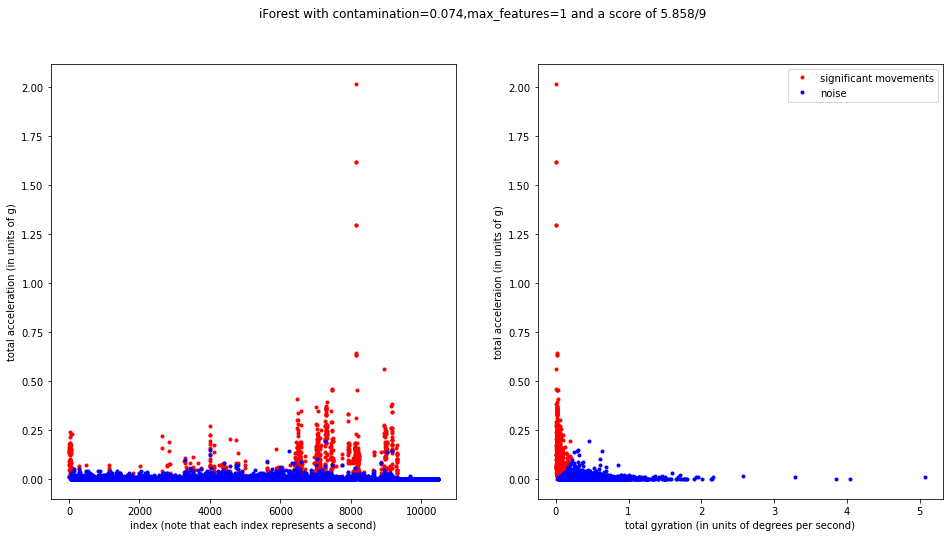

In [10]:
iForest = IsolationForest(n_estimators = 100, max_features = 1,\
                          contamination = 0.074, random_state = 0).fit(X_train)
with open ('/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Models/iForest.pkl',"wb") as f:
    pickle.dump(iForest,f)
output = iForest.predict(X_train)
true_false = []
                
for item in output:
    if item == 1:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df[true_false]
actuals = df[[not i for i in true_false]]
                
plt.figure(figsize = (16,8))
plt.suptitle('iForest with contamination={},max_features={} and a score of {}/9'.format(0.074,1,5.858))            

plt.subplot(121)
plt.plot(anomalies['index'],anomalies.accTotal,'r.')
plt.plot(actuals['index'],actuals.accTotal,'b.')
plt.xlabel('index (note that each index represents a second)')
plt.ylabel('total acceleration (in units of g)')

plt.subplot(122)
plt.plot(1/(anomalies.gyrTotal),(anomalies.accTotal),'r.')
plt.plot(1/(actuals.gyrTotal),(actuals.accTotal),'b.')
plt.xlabel('total gyration (in units of degrees per second)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])

plt.show()

# the right curve shows some promise 

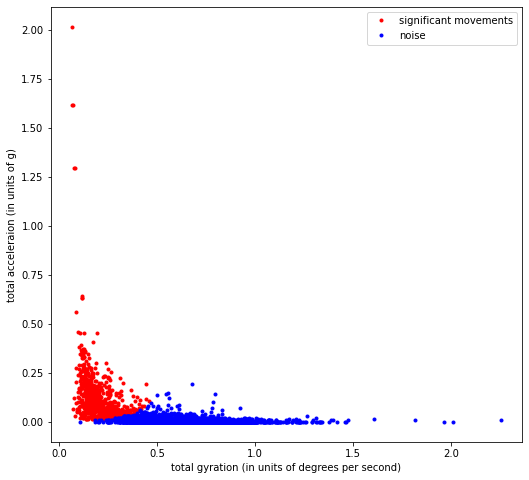

In [11]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)

plt.plot(np.power(1/(anomalies.gyrTotal),1/2),(anomalies.accTotal),'r.')
plt.plot(np.power(1/(actuals.gyrTotal),1/2),(actuals.accTotal),'b.')
plt.xlabel('total gyration (in units of degrees per second)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])


ax.set_aspect('equal', adjustable='box')

plt.show()


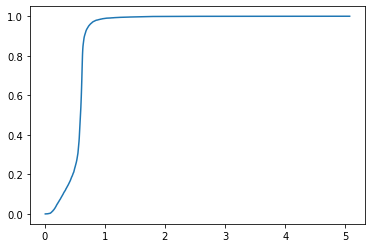

In [12]:
# this is a difficult problem... Dr Olver provided a suggestion: ECDF

#let's redefine
from statsmodels.distributions.empirical_distribution import ECDF


x = 1/(actuals.gyrTotal)
y = actuals.accTotal
ecdf = ECDF(x)
plt.plot(ecdf.x, ecdf.y)


(array([4.320e+02, 1.040e+03, 3.584e+03, 4.362e+03, 1.740e+02, 4.200e+01,
        2.400e+01, 1.900e+01, 1.000e+01, 4.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <BarContainer object of 20 artists>)

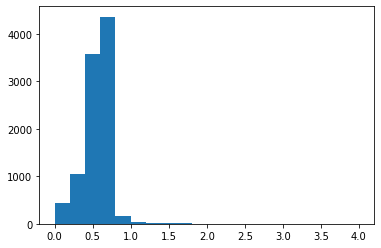

In [13]:
bins_list = [i/5 for i in range(21)]
plt.hist(x,bins = bins_list)

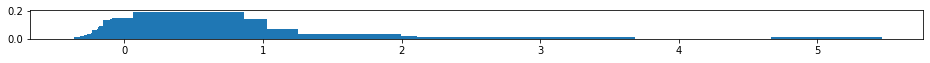

In [30]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)
plt.bar(x,y)
ax.set_aspect('equal', adjustable='box')



In [31]:
# based on reading Dr Olver's email, my underatanding is that we can create a kernel density plot, and then fit it.
# so essentially, treat the blue data like a histogram (sort of like hte bar chart above shows...)
# THEN, create a kernel density plot from it
# then fit the kernel density plot between ~ 0 and 0.2

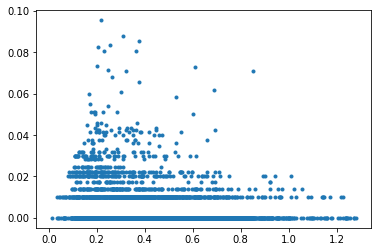

In [120]:
# first thing, we need to make sure of the kernel density function actually outputs points or not..
#checked: it does so on matlab (probably on Python too...)
df_new = pd.DataFrame(data = {'x':x,'y':y})
df_new.reset_index(inplace = True,drop = True)
df_new = df_new[(df_new.x < 1.3) & (df_new.y < 0.1)]
#sanity check
plt.plot(df_new.x,df_new.y,'.')

In [135]:
def convert_to_hist(df,nbins = 50,normalise = True):
    """ converts a scatter plot into a histogram. Note that for this to work best, your scatter plot must 'look'
    like a distribution that could be turned into a histogram, i.e. it must have some sort of hump.
    Components:
    df: the data that you are feeding the function. Must have two columns, x and y for the axes respectively
    nbins: number of bins to segement the data into
    normalise (optional): normalises the resulting histogram
    """
    x_values = []
    y_values = []
    x_unique = df.x.unique()
    x_max = df.x.max()
    x_min = df.x.min()
    bins = np.linspace(x_min,x_max,nbins)
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(111)
    for i in range(len(bins) - 1):
        y = df.y[(df.x > bins[i]) & (df.x < bins[i+1])]
        y_max = y.max()
        x_mid = (bins[i]+bins[i+1])/2
        y_values.append(y_max)
        x_values.append(x_mid)
        plt.plot(x_mid,y_max,'r.')
        """
        y_max = y.max()
        plt.plot(x,y_max,'.')
        """
    ax.set_aspect('equal')
    return x_values,y_values

[0.024531932113430605, 0.050416824495068006, 0.0763017168767054, 0.1021866092583428, 0.1280715016399802, 0.15395639402161762, 0.17984128640325503, 0.2057261787848924]


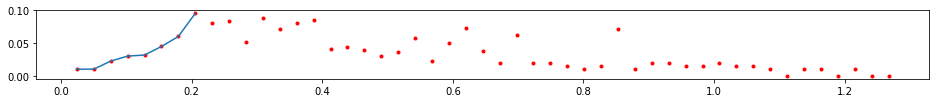

In [161]:
x,y = convert_to_hist(df_new)
#plt.plot(1/(anomalies.gyrTotal),(anomalies.accTotal),'b.')
x = x[0:8]
y = y[0:8]
print(x)
plt.plot(x,y)

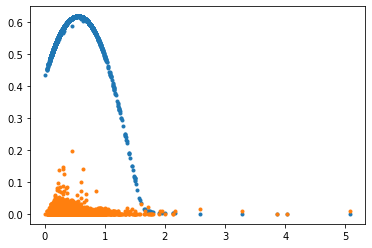

In [112]:
from sklearn.neighbors import KernelDensity as KDE

KDE = KDE(bandwidth = 1,kernel='epanechnikov')
KDE.fit(np.asarray(df_new))
score = KDE.score_samples(np.asarray(df_new))
plt.plot(np.asarray(df_new)[:, 0], np.exp(score),'.')
plt.plot(np.asarray(df_new)[:, 0], np.asarray(df_new)[:, 1],'.')

[ 0.09465538 -0.3427968   0.23784523  0.01817975]


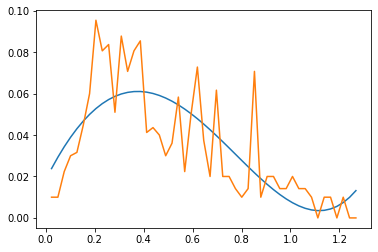

In [159]:
from scipy.optimize import curve_fit

def func(x,a,b,c,d):
    x = np.asarray(x)
    return d+c*x + b*(np.power(x,2)) + a*(np.power(x,4))

popt, pcov = curve_fit(func, x, y)
plt.plot(x, func(x, *popt) )
plt.plot(x,y)
#'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt)
print(popt)

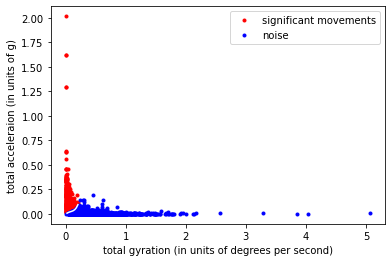

In [153]:
plt.plot(1/(anomalies.gyrTotal),(anomalies.accTotal),'r.')
plt.plot(1/(actuals.gyrTotal),(actuals.accTotal),'b.')
plt.plot(x,func(x,*popt),'white')
plt.xlabel('total gyration (in units of degrees per second)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])